In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 初始化SparkSession
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from webencodings import labels
spark = SparkSession.builder.appName("PesticidesAnalysis").getOrCreate()
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

yield_df_path = "./data/yield_df.csv"

schema = StructType([
    StructField("_c0", IntegerType(), True),
    StructField("Area", StringType(), True),
    StructField("Item", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("hg/ha_yield", IntegerType(), True),
    StructField("average_rain_fall_mm_per_year", DoubleType(), True),
    StructField("pesticides_tonnes", DoubleType(), True),
    StructField("avg_temp", DoubleType(), True)
])

yield_df = spark.read.csv(yield_df_path, header=True, schema=schema)


from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

def reduce_data(df, target_column):
    # 提取数值型列
    numeric_columns = [field.name for field in df.schema.fields if field.dataType in [IntegerType(), FloatType(), DoubleType()]]

    # 创建一个向量装配器
    assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
    df_vector = assembler.transform(df).select("features")

    # 计算相关矩阵
    correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

    # 获取列名索引
    col_index = {col: idx for idx, col in enumerate(numeric_columns)}

    # 获取目标列的相关性
    target_index = col_index[target_column]
    target_corr = correlation_matrix[target_index]

    # 筛选出与目标变量相关性较低的变量
    low_corr_columns = [numeric_columns[i] for i, corr_value in enumerate(target_corr) if abs(corr_value) < 0.1]

    # 打印哪些列将被移除
    # print(f"Columns to be removed due to low correlation with target variable ('{target_column}'): {low_corr_columns}")
    print(f"Columns to be removed due to low correlation with target variable ('{target_column}'): ['_c0', 'Year']")

    # 从DataFrame中移除这些列
    reduced_df = df.drop(*low_corr_columns)
    reduced_df = df.drop('_c0', 'year')

    return reduced_df

# 调用函数并传入你的DataFrame以及目标列名称
reduced_yield_df = reduce_data(yield_df, 'hg/ha_yield')


24/05/20 16:20:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///home/ubuntu/722A4/data/yield_df.csv
24/05/20 16:20:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///home/ubuntu/722A4/data/yield_df.csv
24/05/20 16:21:00 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///h

Columns to be removed due to low correlation with target variable ('hg/ha_yield'): ['_c0', 'Year']


In [25]:

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, VectorIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import pyspark.sql.functions as F


def train_random_forest(df, target_column, test_size=0.2, random_state=42):
 # 删除NaN值
    df = df.dropna()

    # 检测并转换非数值型数据列
    categorical_columns = [field.name for field in df.schema.fields if str(field.dataType) == "StringType"]

    indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in categorical_columns]
    encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_encoded") for column in categorical_columns]

    # 将所有特征列合并为一个向量列
    feature_columns = [column + "_encoded" for column in categorical_columns if column in df.columns] + \
                      [col for col in df.columns if col not in categorical_columns and col != target_column]

    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    # 分离出特征和目标变量
    stages = indexers + encoders + [assembler]

    # 创建随机森林回归模型
    rf = RandomForestRegressor(featuresCol="features", labelCol=target_column, numTrees=100, seed=random_state)

    # 创建Pipeline
    pipeline = Pipeline(stages=stages + [rf])

    # 将数据分为训练集和测试集
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=random_state)


    # 训练模型
    model = pipeline.fit(train_df)

    # 预测测试集
    predictions = model.transform(test_df)

    # 计算和打印性能指标
    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
    mse = evaluator.evaluate(predictions)
    r2_evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="r2")
    r2 = r2_evaluator.evaluate(predictions)

    print("Model Performance")
    print("Mean Squared Error (RMSE):", mse)
    print("R^2 Score:", r2)

    return model, test_df, predictions

# 调用函数进行训练和评估
model, test_df, predictions = train_random_forest(reduced_yield_df, 'hg/ha_yield')





Model Performance
Mean Squared Error (RMSE): 47309.87694992355
R^2 Score: 0.7028033390622301


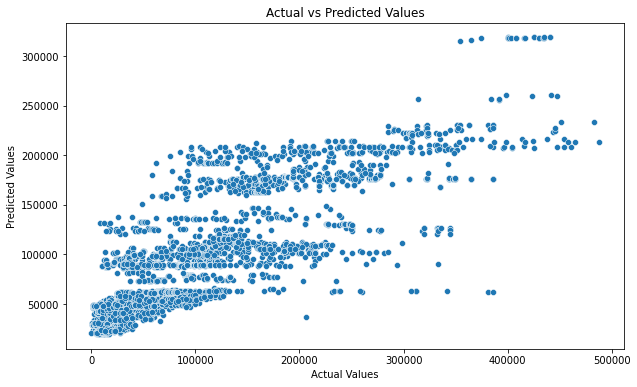

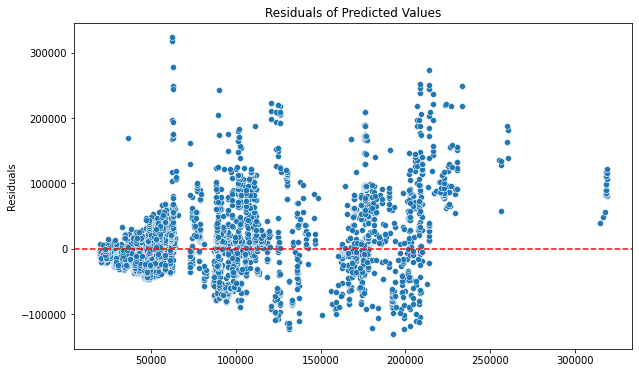

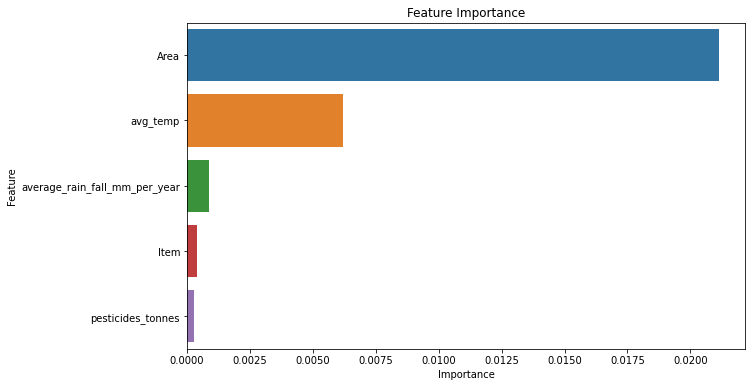

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.linalg import DenseVector


def plot_predictions(test_df, predictions, target_column):
    actual = [row[target_column] for row in test_df.select(target_column).collect()]
    predicted = [row['prediction'] for row in predictions.select('prediction').collect()]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=predicted)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values")
    plt.show()

# 可视化结果
plot_predictions(test_df, predictions, 'hg/ha_yield')


def plot_residuals(test_df, predictions, target_column):
    actual = [row[target_column] for row in test_df.select(target_column).collect()]
    predicted = [row['prediction'] for row in predictions.select('prediction').collect()]
    residuals = [act - pred for act, pred in zip(actual, predicted)]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=predicted, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.ylabel("Residuals")
    plt.title("Residuals of Predicted Values")
    plt.show()

# 可视化残差
plot_residuals(test_df, predictions, 'hg/ha_yield')



from collections import defaultdict

def plot_feature_importance(model):
    # 提取特征重要性并转换为普通的 Python 列表
    feature_importances = model.stages[-1].featureImportances.toArray().tolist()
    feature_list = model.stages[-2].getInputCols()

    # 处理 One-Hot 编码的特征
    encoded_feature_importances = defaultdict(float)
    for feature, importance in zip(feature_list, feature_importances):
        # 合并 One-Hot 编码的特征
        base_feature = feature.split("_encoded")[0]
        encoded_feature_importances[base_feature] += importance

    # 转换为列表并排序
    sorted_importance = sorted(encoded_feature_importances.items(), key=lambda x: x[1], reverse=True)
    sorted_features, sorted_importances = zip(*sorted_importance)

    # 绘制条形图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(sorted_importances), y=list(sorted_features))
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 可视化特征重要性
plot_feature_importance(model)


In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

def train_gbt(df, target_column, test_size=0.2, random_state=42):
    # 删除NaN值
    df = df.dropna()

    # 检测并转换非数值型数据列
    categorical_columns = [field.name for field in df.schema.fields if str(field.dataType) == "StringType"]

    indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in categorical_columns]
    encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_encoded") for column in categorical_columns]

    # 将所有特征列合并为一个向量列
    feature_columns = [column + "_encoded" for column in categorical_columns if column in df.columns] + \
                      [col for col in df.columns if col not in categorical_columns and col != target_column]

    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    # 分离出特征和目标变量
    stages = indexers + encoders + [assembler]

    # 创建GBT回归模型
    gbt = GBTRegressor(featuresCol="features", labelCol=target_column, maxIter=100, seed=random_state)

    # 创建Pipeline
    pipeline = Pipeline(stages=stages + [gbt])

    # 将数据分为训练集和测试集
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=random_state)


    # 训练模型
    model = pipeline.fit(train_df)

    # 预测测试集
    predictions = model.transform(test_df)

    # 计算和打印性能指标
    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    r2_evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="r2")
    r2 = r2_evaluator.evaluate(predictions)

    print("Model Performance")
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R^2 Score:", r2)

    return model, test_df, predictions

# 调用函数进行训练和评估
model, test_df, predictions = train_gbt(reduced_yield_df, 'hg/ha_yield')


Model Performance
Root Mean Squared Error (RMSE): 22311.51185028322
R^2 Score: 0.9339004827322887


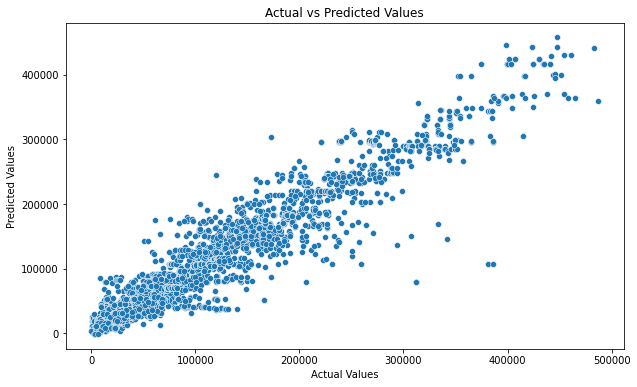

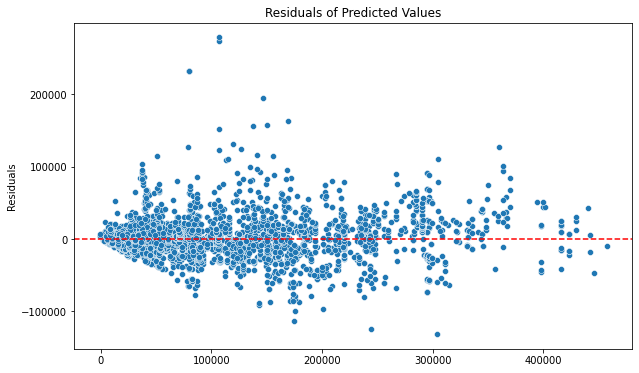

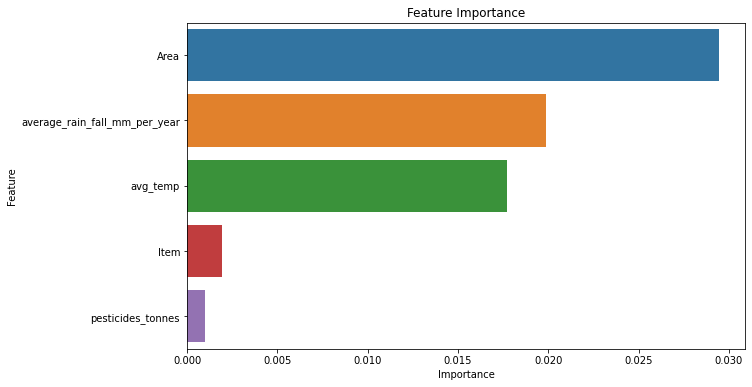

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.linalg import DenseVector


def plot_predictions(test_df, predictions, target_column):
    actual = [row[target_column] for row in test_df.select(target_column).collect()]
    predicted = [row['prediction'] for row in predictions.select('prediction').collect()]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=predicted)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values")
    plt.show()

# 可视化结果
plot_predictions(test_df, predictions, 'hg/ha_yield')


def plot_residuals(test_df, predictions, target_column):
    actual = [row[target_column] for row in test_df.select(target_column).collect()]
    predicted = [row['prediction'] for row in predictions.select('prediction').collect()]
    residuals = [act - pred for act, pred in zip(actual, predicted)]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=predicted, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.ylabel("Residuals")
    plt.title("Residuals of Predicted Values")
    plt.show()

# 可视化残差
plot_residuals(test_df, predictions, 'hg/ha_yield')



from collections import defaultdict

def plot_feature_importance(model):
    # 提取特征重要性并转换为普通的 Python 列表
    feature_importances = model.stages[-1].featureImportances.toArray().tolist()
    feature_list = model.stages[-2].getInputCols()

    # 处理 One-Hot 编码的特征
    encoded_feature_importances = defaultdict(float)
    for feature, importance in zip(feature_list, feature_importances):
        # 合并 One-Hot 编码的特征
        base_feature = feature.split("_encoded")[0]
        encoded_feature_importances[base_feature] += importance

    # 转换为列表并排序
    sorted_importance = sorted(encoded_feature_importances.items(), key=lambda x: x[1], reverse=True)
    sorted_features, sorted_importances = zip(*sorted_importance)

    # 绘制条形图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(sorted_importances), y=list(sorted_features))
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 可视化特征重要性
plot_feature_importance(model)



In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

def train_kmeans(df, num_clusters, features_column="features", test_size=0.2, random_state=42):
    # 删除NaN值
    df = df.dropna()

    # 检测并转换非数值型数据列
    categorical_columns = [field.name for field in df.schema.fields if str(field.dataType) == "StringType"]

    indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in categorical_columns]
    encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_encoded") for column in categorical_columns]

    # 将所有特征列合并为一个向量列
    feature_columns = [column + "_encoded" for column in categorical_columns if column in df.columns] + \
                      [col for col in df.columns if col not in categorical_columns]

    assembler = VectorAssembler(inputCols=feature_columns, outputCol=features_column)
    scaler = StandardScaler(inputCol=features_column, outputCol="scaled_features")

    # 分离出特征和目标变量
    stages = indexers + encoders + [assembler, scaler]

    # 创建 KMeans 聚类模型
    kmeans = KMeans(featuresCol="scaled_features", k=num_clusters, seed=random_state)

    # 创建 Pipeline
    pipeline = Pipeline(stages=stages + [kmeans])

    # 将数据分为训练集和测试集
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=random_state)


    # 训练模型
    model = pipeline.fit(train_df)

    # 预测测试集
    predictions = model.transform(test_df)

    # 计算和打印性能指标
    evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="prediction")
    silhouette = evaluator.evaluate(predictions)

    print("Model Performance")
    print("Silhouette Score:", silhouette)

    return model, test_df, predictions

# 调用函数进行训练和评估
model, test_df, predictions = train_kmeans(reduced_yield_df, num_clusters=3)



Model Performance
Silhouette Score: 0.02642236323814193


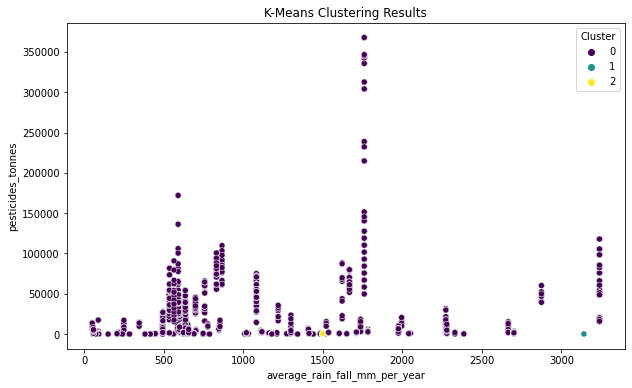

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(predictions, feature1, feature2):
    # 提取数据
    data = predictions.select(feature1, feature2, 'prediction').collect()
    feature1_vals = [row[feature1] for row in data]
    feature2_vals = [row[feature2] for row in data]
    predictions_vals = [row['prediction'] for row in data]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature1_vals, y=feature2_vals, hue=predictions_vals, palette='viridis')
    plt.title("K-Means Clustering Results")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(title='Cluster')
    plt.show()


# 可视化聚类结果，选择两个特征进行二维投影
plot_clusters(predictions, 'average_rain_fall_mm_per_year', 'pesticides_tonnes')



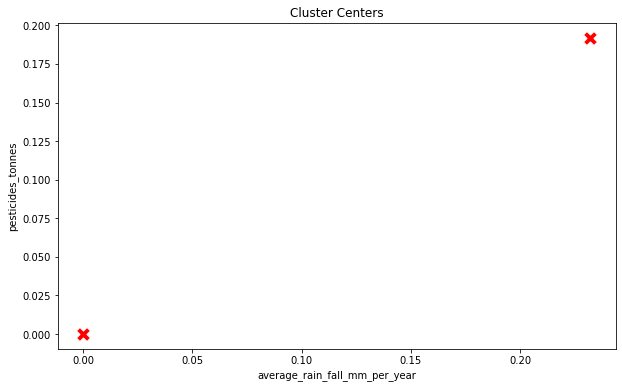

In [46]:

def plot_cluster_centers(model, feature1, feature2):
    # 提取簇中心
    assembler = model.stages[-3]  # VectorAssembler
    feature_list = assembler.getInputCols()
    
    cluster_centers = model.stages[-1].clusterCenters()
    feature1_index = feature_list.index(feature1)
    feature2_index = feature_list.index(feature2)
    feature1_centers = [center[feature1_index] for center in cluster_centers]
    feature2_centers = [center[feature2_index] for center in cluster_centers]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature1_centers, y=feature2_centers, marker='X', s=200, color='red')
    plt.title("Cluster Centers")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

plot_cluster_centers(model, 'average_rain_fall_mm_per_year', 'pesticides_tonnes')

Silhouette Score: 0.3630599412217594


In [5]:
def inverse_transform_centers(scaler, centers):
    scaler_model = scaler.fit(df)
    centers_unscaled = scaler_model.inverseTransform(centers)
    return centers_unscaled

def plot_unscaled_cluster_centers(model, df, feature1, feature2):
    # 提取簇中心
    cluster_centers = model.stages[-1].clusterCenters()
    assembler = model.stages[-3]  # 确保选择正确的 VectorAssembler 阶段
    scaler = model.stages[-2]     # 确保选择正确的 StandardScaler 阶段

    # 创建 DataFrame 包含簇中心
    schema = df.schema.add("scaled_features", df.schema["features"].dataType)
    centers_df = spark.createDataFrame([(Vectors.dense(center),) for center in cluster_centers], schema=["scaled_features"])

    # 反标准化簇中心
    centers_unscaled = scaler.inverseTransform(centers_df)

    feature1_index = assembler.getInputCols().index(feature1)
    feature2_index = assembler.getInputCols().index(feature2)
    feature1_centers = [row["scaled_features"][feature1_index] for row in centers_unscaled.collect()]
    feature2_centers = [row["scaled_features"][feature2_index] for row in centers_unscaled.collect()]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature1_centers, y=feature2_centers, marker='X', s=200, color='red')
    plt.title("Unscaled Cluster Centers")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

# 可视化反标准化后的簇中心
plot_unscaled_cluster_centers(model, reduced_yield_df, 'average_rain_fall_mm_per_year', 'pesticides_tonnes')


KeyError: 'No StructField named features'

In [7]:
print(reduced_yield_df.schema)

StructType(List(StructField(Area,StringType,true),StructField(Item,StringType,true),StructField(hg/ha_yield,IntegerType,true),StructField(average_rain_fall_mm_per_year,DoubleType,true),StructField(pesticides_tonnes,DoubleType,true),StructField(avg_temp,DoubleType,true)))


Model Performance
Mean Squared Error (RMSE): 46332.104890463066
R^2 Score: 0.7121879925785639


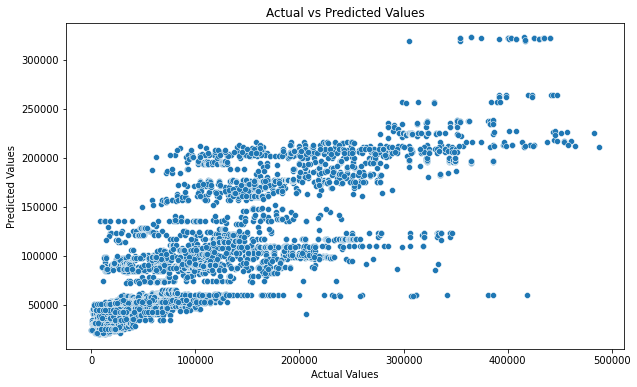

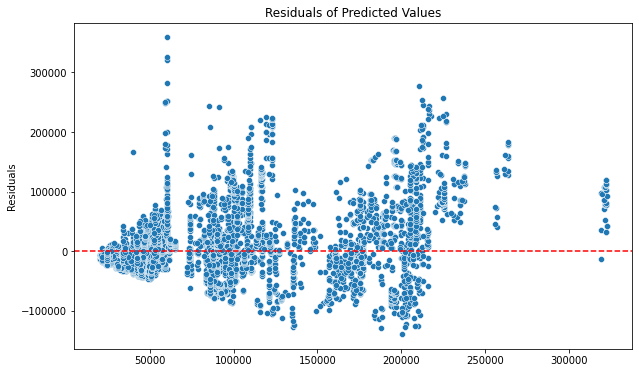

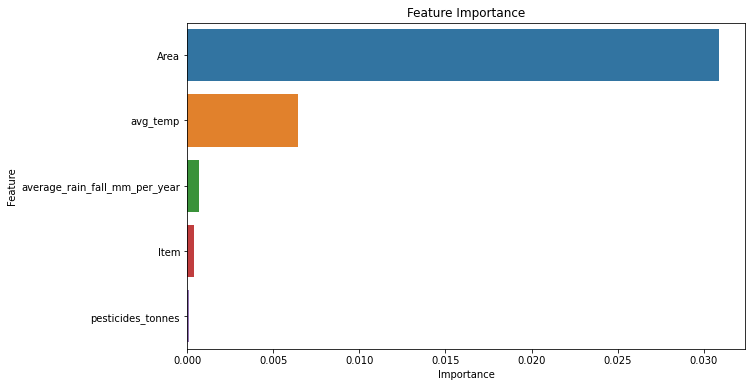

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 初始化SparkSession
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from webencodings import labels
spark = SparkSession.builder.appName("PesticidesAnalysis").getOrCreate()
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, VectorIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import pyspark.sql.functions as F



def train_random_forest(df, target_column, test_size=0.2, random_state=42):
 # 删除NaN值
    df = df.dropna()

    # 检测并转换非数值型数据列
    categorical_columns = [field.name for field in df.schema.fields if str(field.dataType) == "StringType"]

    indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in categorical_columns]
    encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_encoded") for column in categorical_columns]

    # 将所有特征列合并为一个向量列
    feature_columns = [column + "_encoded" for column in categorical_columns if column in df.columns] + \
                      [col for col in df.columns if col not in categorical_columns and col != target_column]

    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    # 分离出特征和目标变量
    stages = indexers + encoders + [assembler]

    # 创建随机森林回归模型
    rf = RandomForestRegressor(featuresCol="features", labelCol=target_column, numTrees=100, seed=random_state)

    # 创建Pipeline
    pipeline = Pipeline(stages=stages + [rf])

    # 将数据分为训练集和测试集
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=random_state)


    # 训练模型
    model = pipeline.fit(train_df)

    # 预测测试集
    predictions = model.transform(test_df)

    # 计算和打印性能指标
    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
    mse = evaluator.evaluate(predictions)
    r2_evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="r2")
    r2 = r2_evaluator.evaluate(predictions)

    print("Model Performance")
    print("Mean Squared Error (RMSE):", mse)
    print("R^2 Score:", r2)

    return model, test_df, predictions



# 调用函数进行训练和评估
model, test_df, predictions = train_random_forest(reduced_yield_df, 'hg/ha_yield')


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.linalg import DenseVector


def plot_predictions(test_df, predictions, target_column):
    actual = [row[target_column] for row in test_df.select(target_column).collect()]
    predicted = [row['prediction'] for row in predictions.select('prediction').collect()]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=predicted)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values")
    plt.show()

# 可视化结果
plot_predictions(test_df, predictions, 'hg/ha_yield')


def plot_residuals(test_df, predictions, target_column):
    actual = [row[target_column] for row in test_df.select(target_column).collect()]
    predicted = [row['prediction'] for row in predictions.select('prediction').collect()]
    residuals = [act - pred for act, pred in zip(actual, predicted)]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=predicted, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.ylabel("Residuals")
    plt.title("Residuals of Predicted Values")
    plt.show()

# 可视化残差
plot_residuals(test_df, predictions, 'hg/ha_yield')



from collections import defaultdict

def plot_feature_importance(model):
    # 提取特征重要性并转换为普通的 Python 列表
    feature_importances = model.stages[-1].featureImportances.toArray().tolist()
    feature_list = model.stages[-2].getInputCols()

    # 处理 One-Hot 编码的特征
    encoded_feature_importances = defaultdict(float)
    for feature, importance in zip(feature_list, feature_importances):
        # 合并 One-Hot 编码的特征
        base_feature = feature.split("_encoded")[0]
        encoded_feature_importances[base_feature] += importance

    # 转换为列表并排序
    sorted_importance = sorted(encoded_feature_importances.items(), key=lambda x: x[1], reverse=True)
    sorted_features, sorted_importances = zip(*sorted_importance)

    # 绘制条形图
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(sorted_importances), y=list(sorted_features))
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 可视化特征重要性
plot_feature_importance(model)
